In [5]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

data = pd.read_csv("Makerspace Statements.csv")

data_cleaned = []
dictionary_tokens = []
for doc in data["Description"]:
    doc_lower = doc.lower()
    doc_no_numbers = re.sub(r'\d+', '', doc_lower)
    doc_no_punctuation = re.sub(r'[^\w\s]', '', doc_no_numbers)
    tokens = word_tokenize(doc_no_punctuation)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in tokens if word.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    filtered_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    cleaned_doc = ' '.join(filtered_words)
    dictionary_tokens.append(filtered_words)
    data_cleaned.append(cleaned_doc)

tfidf_vectorizer = TfidfVectorizer(min_df=10)
tfidf_matrix = tfidf_vectorizer.fit_transform(data_cleaned)


In [6]:
import itertools

def jaccard_similarity(topic_1, topic_2):
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))          
    return float(len(intersection))/float(len(union))

def average_jaccard_similarity(model_topics):
    total_similarity = 0
    num_pairs = 0
    for pair in itertools.combinations(model_topics, 2):
        total_similarity += jaccard_similarity(pair[0], pair[1])
        num_pairs += 1
    return total_similarity / num_pairs

Topic 2: [['innovation', 'development', 'economic', 'business', 'manufacturing', 'entrepreneurship', 'region', 'value', 'diversity', 'hackerspace'], ['able', 'meet', 'mentoring', 'metalworking', 'model', 'modern', 'movement', 'needed', 'network', 'new']]
[142  95]
Topic 3: [['innovation', 'development', 'economic', 'business', 'manufacturing', 'entrepreneurship', 'value', 'region', 'hackerspace', 'studio'], ['ability', 'provide', 'promote', 'programmer', 'problem', 'printing', 'possible', 'passionate', 'passion', 'partner'], ['accessible', 'new', 'next', 'offer', 'organization', 'otherwise', 'personal', 'network', 'physical', 'play']]
[130 102   5]
Topic 4: [['innovation', 'development', 'economic', 'business', 'manufacturing', 'entrepreneurship', 'region', 'value', 'diversity', 'hackerspace'], ['access', 'outreach', 'otherwise', 'operated', 'offer', 'new', 'needed', 'movement', 'monthly', 'mind'], ['ability', 'printer', 'power', 'possibility', 'physical', 'personal', 'people', 'others

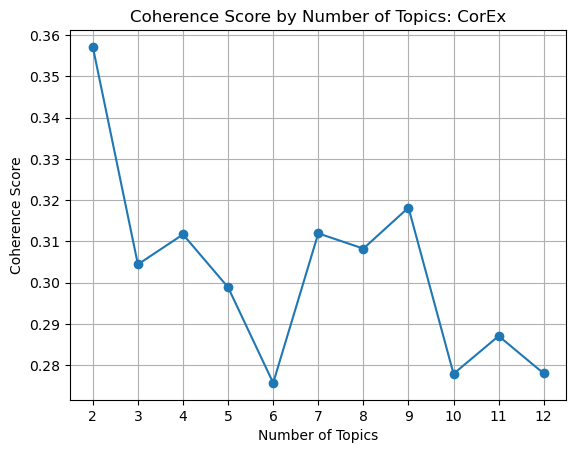

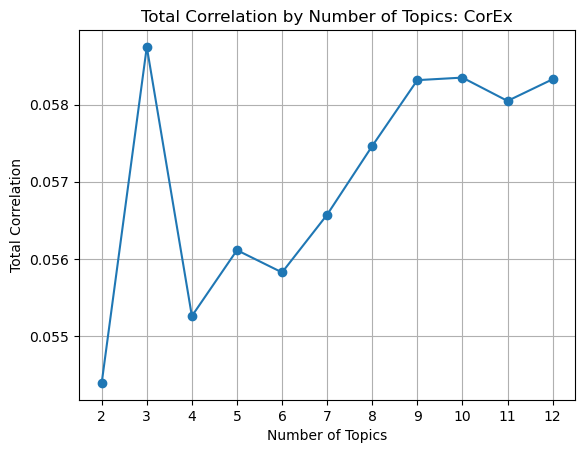

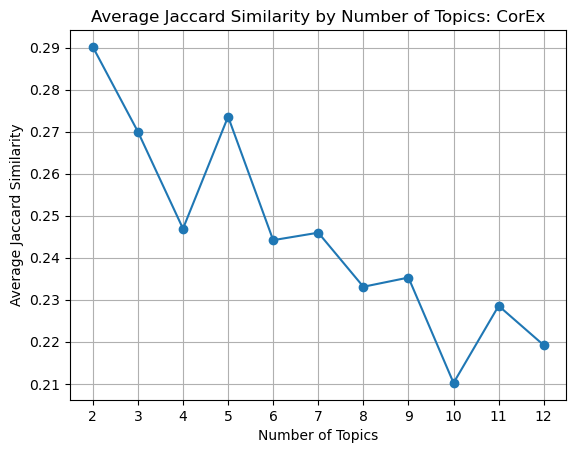

In [7]:
from corextopic import corextopic as ct
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt
import numpy as np

anchor_strength = 10
tfidf = tfidf_matrix
vocabulary = list(tfidf_vectorizer.get_feature_names_out())

keywords =   [
              ["creativity", "creative", "creator", "creators", "imagine", "imagination", "new"], 
              ["skill", "skills", "learn", "learning", "problem solving", "employment", "job", "jobs"], 
              ["entrepreneur", "entrepreneurs", "entrepreneurship", "innovation", "innovator", "innovators", "business", "owner", "opportunity", "accelerator", "accelerating"],
              ["prototype", "prototypes", "prototyping"], 
              ["economic opportunity", "innovation economy", "economic growth", "opportunity", "economy", "innovation", "growth"], 
              ["collaboration", "community", "team", "unity", "collective", "networking", "support", "together", "shared"], 
              ["diversity", "equity", "inclusion", "everyone", "anyone", "all kinds", "for all", "supportive", "empowerment", "empower", "inclusive", "access", "accessibility", "belonging", "variety of voices", "fair"],
              ["empower", "empowerment", "autonomy", "agency", "self-efficacy", "confidence", "motivation", "develop", "goal", "grow", "growth", "potential", "goals", "mastery"]
             ]

keywords = [[word for word in topic if word in vocabulary] for topic in keywords]

keywords_minimal = [ 
                    ["collaboration", "community", "teamwork", "diversity", "inclusion", "equity", "self-efficacy", "empowerment", "agency"],
                    ["creativity", "skills", "jobs", "careers", "entrepreneurship", "innovation", "business", "prototyping", "economy"]
]

keywords_minimal = [[word for word in topic if word in vocabulary] for topic in keywords_minimal]

dictionary = corpora.Dictionary(dictionary_tokens)
corpus = [dictionary.doc2bow(doc) for doc in dictionary_tokens]

topic_range = range(2, 13)

coherence_scores = []
total_correlation = []
average_of_averages = []

for n_topics in topic_range:
    topic_model = ct.Corex(n_hidden=n_topics, seed=1, max_iter=500)
    topic_model.fit(tfidf, words=vocabulary)
    topics = topic_model.get_topics()
    topics_words = [[word for word, _, _ in topic if word in vocabulary] for topic in topics]
    print(f"Topic {n_topics}: {topics_words}")
    
    average_similarities = [average_jaccard_similarity(topic) for topic in topics_words]
    average_of_averages.append(sum(average_similarities) / len(average_similarities) if average_similarities else 0)
    
    cm = CoherenceModel(topics=topics_words, texts=dictionary_tokens, dictionary=dictionary, coherence='c_v')
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)

    correlation = topic_model.tc
    total_correlation.append(correlation)

    topic_distribution = topic_model.transform(tfidf_matrix)
    doc_topic_distribution = np.argmax(topic_distribution, axis=1)  
    print(np.bincount(doc_topic_distribution))

# Plotting
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score by Number of Topics: CorEx')
plt.xticks(topic_range)
plt.grid(True)
plt.show()

plt.plot(topic_range, total_correlation, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Total Correlation')
plt.title('Total Correlation by Number of Topics: CorEx')
plt.xticks(topic_range)
plt.grid(True)
plt.show()

plt.plot(topic_range, average_of_averages, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Average Jaccard Similarity')
plt.title('Average Jaccard Similarity by Number of Topics: CorEx')
plt.xticks(topic_range)
plt.grid(True)
plt.show()



In [8]:
topic_model = ct.Corex(n_hidden=9, seed=1, max_iter=500)
topic_model.fit(tfidf, words=vocabulary, anchors=keywords, anchor_strength=anchor_strength)
topics = topic_model.get_topics()
topics_words = [[word for word, _, _ in topic if word in vocabulary] for topic in topics]
print(f"Topic 9: {topics_words}")

Topic 9: [['creator', 'future', 'amazing', 'exploring', 'hacker', 'new', 'membership', 'may', 'material', 'making'], ['job', 'safety', 'along', 'member', 'otherwise', 'physical', 'possible', 'realize', 'robotics', 'run'], ['business', 'innovation', 'entrepreneurship', 'innovator', 'entrepreneur', 'economic', 'region', 'opportunity', 'development', 'workforce'], ['prototyping', 'prototype', 'manufacturing', 'product', 'small', 'equipment', 'advanced', 'steam', 'adult', 'meet'], ['economy', 'innovation', 'innovative', 'promoting', 'generation', 'connection', 'love', 'passion', 'growth', 'located'], ['support', 'collaboration', 'team', 'together', 'shared', 'family', 'network', 'online', 'partner', 'person'], ['anyone', 'everyone', 'scientist', 'pursue', 'engineer', 'set', 'friendly', 'passionate', 'science', 'know'], ['empower', 'potential', 'develop', 'growth', 'grow', 'vision', 'value', 'hub', 'offering', 'success'], ['across', 'knowledge', 'likeminded', 'local', 'made', 'meeting', 'mo

In [9]:
second_topic_model = ct.Corex(n_hidden=2, seed=1, max_iter=500)
second_topic_model.fit(tfidf, words=vocabulary, anchors=keywords_minimal, anchor_strength=anchor_strength)
topics = second_topic_model.get_topics()
topics_words = [[word for word, _, _ in topic if word in vocabulary] for topic in topics]
print(f"Topic {2}: {topics_words}")

Topic 2: [['collaboration', 'experimentation', 'benefit', 'cultural', 'talk', 'exchange', 'research', 'scientific', 'artistic', 'mentoring'], ['business', 'innovation', 'prototyping', 'entrepreneurship', 'economy', 'manufacturing', 'development', 'industrial', 'training', 'economic']]


In [10]:
topic_distribution = topic_model.transform(tfidf_matrix)
doc_topic_distribution = np.argmax(topic_distribution, axis=1)
topic_counts = np.bincount(doc_topic_distribution)
for topic, count in enumerate(topic_counts, start=1):
    print(f"Topic {topic}: {count} documents")

# Initialize counters for N and P documents per topic
nonprofit = np.zeros(topic_model.tcs.shape[0])
commercial = np.zeros(topic_model.tcs.shape[0])

for doc_idx, topic_idx in enumerate(doc_topic_distribution):
    if data["Nonprofit_Commercial"].iloc[doc_idx] == "N":
        nonprofit[topic_idx] += 1
    elif data["Nonprofit_Commercial"].iloc[doc_idx] == "C":
        commercial[topic_idx] += 1

# Print the counts of N and P documents per topic
for topic, (n_count, c_count) in enumerate(zip(nonprofit, commercial), start=1):
    print(f"Topic {topic}: {round((n_count)/208, 2)} nonprofit documents, {round((c_count)/29, 2)} commercial documents")

topic_proportions = topic_model.p_y_given_x
topic_proportions_df = pd.DataFrame(topic_proportions, columns=[f'Topic {i+1}' for i in range(9)])
topic_proportions_df




Topic 1: 37 documents
Topic 2: 7 documents
Topic 3: 14 documents
Topic 4: 30 documents
Topic 5: 5 documents
Topic 6: 44 documents
Topic 7: 16 documents
Topic 8: 22 documents
Topic 9: 62 documents
Topic 1: 0.15 nonprofit documents, 0.17 commercial documents
Topic 2: 0.03 nonprofit documents, 0.03 commercial documents
Topic 3: 0.06 nonprofit documents, 0.07 commercial documents
Topic 4: 0.12 nonprofit documents, 0.17 commercial documents
Topic 5: 0.02 nonprofit documents, 0.03 commercial documents
Topic 6: 0.2 nonprofit documents, 0.1 commercial documents
Topic 7: 0.07 nonprofit documents, 0.03 commercial documents
Topic 8: 0.1 nonprofit documents, 0.07 commercial documents
Topic 9: 0.25 nonprofit documents, 0.31 commercial documents


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.016413,0.019397,0.003836,0.062320,0.022233,0.395320,0.980922,0.999996,0.482472
1,0.024099,0.014440,0.007645,0.081477,0.009094,0.187613,0.000001,0.114011,0.481507
2,0.039095,0.018780,0.000587,0.062490,0.007747,0.143966,0.980398,0.087161,0.514050
3,0.000893,0.022166,0.012666,0.056617,0.999900,0.137798,0.013734,0.084270,0.481807
4,0.017777,0.007925,0.019688,0.070908,0.038824,0.644911,0.051261,0.816664,0.487996
...,...,...,...,...,...,...,...,...,...
232,0.005770,0.265185,0.999899,0.999880,0.021758,0.053774,0.033963,0.996333,0.472003
233,0.031385,0.006712,0.000257,0.071708,0.006392,0.058388,0.020501,0.093351,0.509348
234,0.012255,0.020509,0.006395,0.073843,0.015857,0.454637,0.039784,0.978233,0.487739
235,0.007307,0.009830,0.000550,0.065746,0.038203,0.127340,0.993068,0.718243,0.497409


In [11]:
topic_distribution = second_topic_model.transform(tfidf_matrix)
doc_topic_distribution = np.argmax(topic_distribution, axis=1)
topic_counts = np.bincount(doc_topic_distribution)
for topic, count in enumerate(topic_counts, start=1):
    print(f"Topic {topic}: {count} documents")

# Initialize counters for N and P documents per topic
nonprofit = np.zeros(second_topic_model.tcs.shape[0])
commercial = np.zeros(second_topic_model.tcs.shape[0])

for doc_idx, topic_idx in enumerate(doc_topic_distribution):
    if data["Nonprofit_Commercial"].iloc[doc_idx] == "N":
        nonprofit[topic_idx] += 1
    elif data["Nonprofit_Commercial"].iloc[doc_idx] == "C":
        commercial[topic_idx] += 1

# Print the counts of N and P documents per topic
for topic, (n_count, c_count) in enumerate(zip(nonprofit, commercial), start=1):
    print(f"Topic {topic}: {round((n_count)/208, 2)} nonprofit documents, {round((c_count)/29, 2)} commercial documents")

topic_proportions = second_topic_model.p_y_given_x
topic_proportions_df = pd.DataFrame(topic_proportions, columns=[f'Topic {i+1}' for i in range(2)])
topic_proportions_df

Topic 1: 175 documents
Topic 2: 62 documents
Topic 1: 0.75 nonprofit documents, 0.66 commercial documents
Topic 2: 0.25 nonprofit documents, 0.34 commercial documents


,Topic 1,Topic 2
0,0.000002,0.042567
1,0.000001,0.019134
2,0.000426,0.004348
3,0.000027,0.999987
4,0.000001,0.995139
...,...,...
232,0.000080,0.999999
233,0.000016,0.004504
234,0.000072,0.076352
235,0.000185,0.005493


Model 2: [['space', 'member', 'project', 'tool', 'people', 'thing', 'community', 'make', 'maker', 'workshop'], ['community', 'mission', 'business', 'innovation', 'maker', 'skill', 'development', 'opportunity', 'creative', 'makerspace']]
[131 106]
Model 3: [['tool', 'make', 'thing', 'maker', 'member', 'space', 'people', 'like', 'community', 'makerspace'], ['community', 'business', 'innovation', 'mission', 'maker', 'development', 'opportunity', 'skill', 'creative', 'entrepreneur'], ['technology', 'art', 'space', 'science', 'project', 'lab', 'community', 'share', 'member', 'learn']]
[85 81 71]
Model 4: [['tool', 'thing', 'make', 'member', 'maker', 'space', 'people', 'like', 'use', 'project'], ['community', 'maker', 'mission', 'creative', 'creativity', 'space', 'value', 'vision', 'support', 'believe'], ['technology', 'art', 'project', 'science', 'space', 'lab', 'member', 'share', 'hackerspace', 'work'], ['business', 'manufacturing', 'innovation', 'development', 'program', 'training', 'entr

/Users/aryarao/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


[49 62 40 27 18 41]
Model 7: [['shop', 'tool', 'maker', 'makerspace', 'metal', 'space', 'equipment', 'class', 'machine', 'laser'], ['community', 'maker', 'mission', 'value', 'creative', 'vision', 'space', 'creativity', 'believe', 'support'], ['space', 'member', 'project', 'hackerspace', 'share', 'workshop', 'work', 'community', 'meeting', 'knowledge'], ['business', 'manufacturing', 'innovation', 'development', 'program', 'training', 'product', 'center', 'entrepreneur', 'new'], ['lab', 'hacker', 'scientist', 'research', 'electronics', 'innovate', 'community', 'idea', 'open', 'play'], ['make', 'thing', 'tool', 'people', 'like', 'making', 'learn', 'place', 'use', 'skill'], ['art', 'technology', 'science', 'new', 'learn', 'interest', 'collaborate', 'teach', 'create', 'makerspace']]
[33 54 43 23 14 40 30]
Model 8: [['make', 'tool', 'thing', 'like', 'use', 'maker', 'makerspace', 'something', 'want', 'learn'], ['community', 'maker', 'mission', 'value', 'creative', 'vision', 'creativity', 'bel

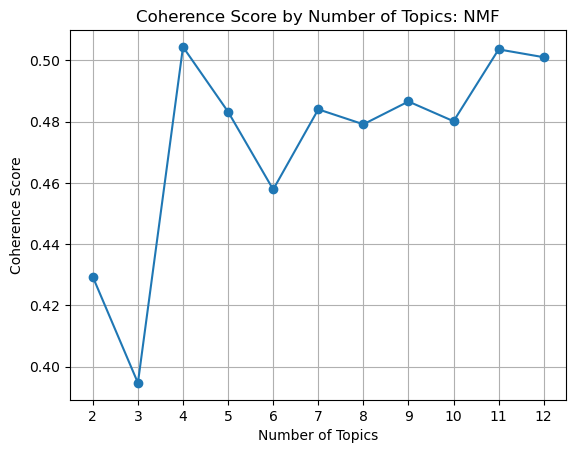

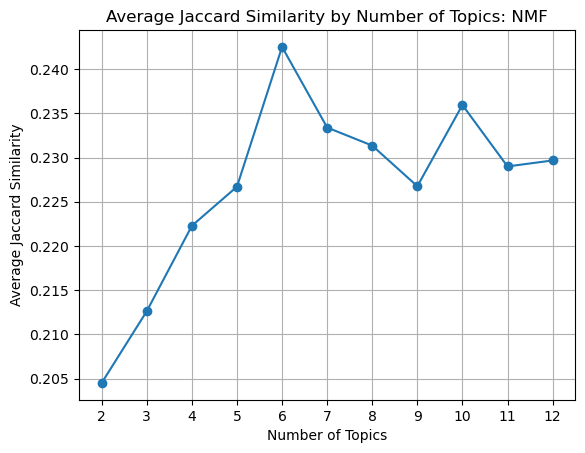

In [12]:
from sklearn.decomposition import NMF

topic_range = range(2, 13)

coherence_scores = []
average_of_averages = [] 

for n_topics in topic_range:
    nmf_model = NMF(n_components=n_topics, random_state=40, max_iter=500)
    nmf_matrix = nmf_model.fit_transform(tfidf_matrix)
    n_top_words = 10
    feature_names = tfidf_vectorizer.get_feature_names_out()
    topics_words = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics_words.append(top_words)
    print(f"Model {topic_idx + 1}: {topics_words}")
    average_similarities = [average_jaccard_similarity(topic) for topic in topics_words]
    average_of_averages.append(sum(average_similarities) / len(average_similarities) if average_similarities else 0) 
    
    cm = CoherenceModel(topics=topics_words, texts=dictionary_tokens, dictionary=dictionary, coherence='c_v')
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)

    topic_distribution = nmf_model.transform(tfidf_matrix)
    doc_topic_distribution = np.argmax(topic_distribution, axis=1)  
    print(np.bincount(doc_topic_distribution))

plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score by Number of Topics: NMF')
plt.xticks(topic_range)
plt.grid(True)
plt.show()

plt.plot(topic_range, average_of_averages, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Average Jaccard Similarity')
plt.title('Average Jaccard Similarity by Number of Topics: NMF')
plt.xticks(topic_range)
plt.grid(True)
plt.show()


In [13]:
nmf_model = NMF(n_components=9, random_state=40, max_iter=500)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)
n_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names_out()
topics_words = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    topics_words.append(top_words)
print(f"Model {topic_idx + 1}: {topics_words}")

topic_distribution = nmf_model.transform(tfidf_matrix)
doc_topic_distribution = np.argmax(topic_distribution, axis=1)
topic_counts = np.bincount(doc_topic_distribution)
for topic, count in enumerate(topic_counts, start=1):
    print(f"Topic {topic}: {count} documents")

# Initialize counters for N and P documents per topic
nonprofit = np.zeros(9)
commercial = np.zeros(9)

for doc_idx, topic_idx in enumerate(doc_topic_distribution):
    if data["Nonprofit_Commercial"].iloc[doc_idx] == "N":
        nonprofit[topic_idx] += 1
    elif data["Nonprofit_Commercial"].iloc[doc_idx] == "C":
        commercial[topic_idx] += 1

# Print the counts of N and P documents per topic
for topic, (n_count, c_count) in enumerate(zip(nonprofit, commercial), start=1):
    print(f"Topic {topic}: {round((n_count)/208, 2)} nonprofit documents, {round((c_count)/29, 2)} commercial documents")

topic_proportions_df = pd.DataFrame(nmf_matrix, columns=[f'Topic {i+1}' for i in range(9)])
topic_proportions_df

Model 9: [['make', 'thing', 'tool', 'use', 'like', 'makerspace', 'making', 'something', 'people', 'need'], ['community', 'mission', 'value', 'vision', 'creative', 'believe', 'creativity', 'support', 'individual', 'life'], ['space', 'member', 'workshop', 'project', 'community', 'volunteer', 'organization', 'event', 'located', 'shared'], ['business', 'manufacturing', 'innovation', 'development', 'program', 'product', 'training', 'center', 'new', 'entrepreneur'], ['lab', 'hacker', 'scientist', 'research', 'electronics', 'innovate', 'community', 'open', 'idea', 'laser'], ['hackerspace', 'people', 'project', 'share', 'group', 'together', 'work', 'new', 'place', 'thing'], ['art', 'technology', 'science', 'learn', 'new', 'teach', 'interest', 'collaborate', 'create', 'makerspace'], ['shop', 'industrial', 'metal', 'class', 'offer', 'facility', 'tool', 'wood', 'equipment', 'studio'], ['maker', 'artist', 'community', 'entrepreneur', 'hobbyist', 'tool', 'engineer', 'tinkerer', 'inventor', 'access'

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.000402,0.358962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023841
1,0.043770,0.192606,0.015035,0.045190,0.019013,0.000000,0.029125,0.000000,0.112958
2,0.000000,0.000000,0.000000,0.000000,0.063094,0.020217,0.000000,0.000000,0.266642
3,0.000000,0.110027,0.000000,0.089067,0.000000,0.058480,0.044419,0.017265,0.007185
4,0.020628,0.123653,0.084092,0.020371,0.000000,0.003632,0.003406,0.251685,0.000000
...,...,...,...,...,...,...,...,...,...
232,0.023738,0.000000,0.008812,0.371141,0.001245,0.000000,0.020700,0.000000,0.000000
233,0.090056,0.000000,0.015403,0.000000,0.000000,0.063746,0.000000,0.086647,0.095656
234,0.054389,0.168785,0.000000,0.000333,0.004552,0.000000,0.037924,0.025028,0.070052
235,0.015712,0.176247,0.112536,0.000000,0.000000,0.069197,0.079453,0.000000,0.038245


In [14]:
nmf_model = NMF(n_components=4, random_state=40, max_iter=500)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)
n_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names_out()
topics_words = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    topics_words.append(top_words)
print(f"Model {topic_idx + 1}: {topics_words}")

topic_distribution = nmf_model.transform(tfidf_matrix)
doc_topic_distribution = np.argmax(topic_distribution, axis=1)
topic_counts = np.bincount(doc_topic_distribution)
for topic, count in enumerate(topic_counts, start=1):
    print(f"Topic {topic}: {count} documents")

# Initialize counters for N and P documents per topic
nonprofit = np.zeros(4)
commercial = np.zeros(4)

for doc_idx, topic_idx in enumerate(doc_topic_distribution):
    if data["Nonprofit_Commercial"].iloc[doc_idx] == "N":
        nonprofit[topic_idx] += 1
    elif data["Nonprofit_Commercial"].iloc[doc_idx] == "C":
        commercial[topic_idx] += 1

# Print the counts of N and P documents per topic
from IPython.display import display, HTML
for topic, (n_count, c_count) in enumerate(zip(nonprofit, commercial), start=1):
    print(f"Topic {topic}: {round((n_count)/208, 2)} nonprofit documents, {round((c_count)/29, 2)} commercial documents")

topic_proportions_df = pd.DataFrame(nmf_matrix, columns=[f'Topic {i+1}' for i in range(4)])
display(HTML(topic_proportions_df.to_html()))

Model 4: [['tool', 'thing', 'make', 'member', 'maker', 'space', 'people', 'like', 'use', 'project'], ['community', 'maker', 'mission', 'creative', 'creativity', 'space', 'value', 'vision', 'support', 'believe'], ['technology', 'art', 'project', 'science', 'space', 'lab', 'member', 'share', 'hackerspace', 'work'], ['business', 'manufacturing', 'innovation', 'development', 'program', 'training', 'entrepreneur', 'equipment', 'center', 'product']]
Topic 1: 71 documents
Topic 2: 69 documents
Topic 3: 65 documents
Topic 4: 32 documents
Topic 1: 0.28 nonprofit documents, 0.45 commercial documents
Topic 2: 0.31 nonprofit documents, 0.17 commercial documents
Topic 3: 0.3 nonprofit documents, 0.1 commercial documents
Topic 4: 0.12 nonprofit documents, 0.28 commercial documents


,Topic 1,Topic 2,Topic 3,Topic 4
0,0.000000,0.367070,0.000000,0.000000
1,0.049152,0.242220,0.016395,0.069770
2,0.065429,0.044029,0.030767,0.000000
3,0.000000,0.129210,0.029500,0.115653
4,0.112645,0.107851,0.035845,0.103832
5,0.117823,0.044765,0.123995,0.008580
6,0.158888,0.114849,0.062891,0.000000
7,0.000000,0.215323,0.009378,0.111799
8,0.000000,0.086269,0.000000,0.212143
9,0.000000,0.180255,0.049095,0.000000


Topic 2: [['community', 'space', 'tool', 'maker', 'member', 'makerspace', 'people', 'new', 'project', 'workshop'], ['community', 'tool', 'maker', 'space', 'member', 'people', 'makerspace', 'project', 'skill', 'thing']]
[158  79]
Topic 3: [['community', 'space', 'member', 'tool', 'makerspace', 'people', 'workshop', 'idea', 'maker', 'project'], ['community', 'space', 'tool', 'member', 'people', 'maker', 'makerspace', 'skill', 'class', 'thing'], ['community', 'maker', 'tool', 'space', 'people', 'new', 'makerspace', 'make', 'art', 'project']]
[ 78  36 123]
Topic 4: [['community', 'space', 'member', 'makerspace', 'tool', 'people', 'workshop', 'idea', 'maker', 'learn'], ['community', 'space', 'member', 'tool', 'people', 'makerspace', 'maker', 'skill', 'class', 'thing'], ['community', 'maker', 'space', 'tool', 'makerspace', 'new', 'access', 'people', 'make', 'art'], ['community', 'tool', 'maker', 'project', 'space', 'people', 'member', 'skill', 'work', 'make']]
[71 26 99 41]
Topic 5: [['commu

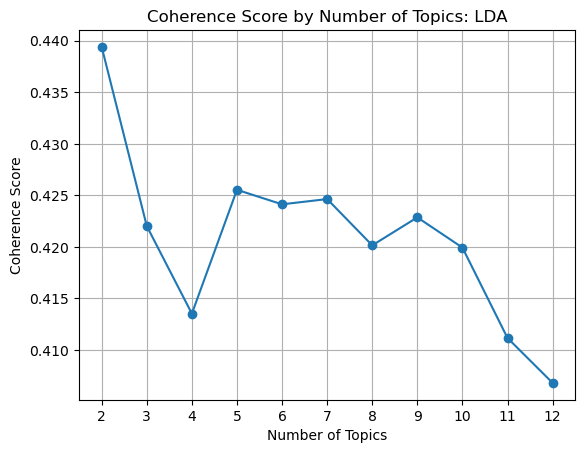

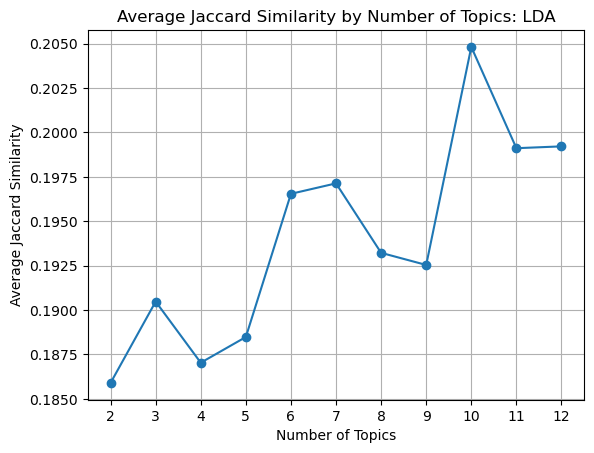

In [15]:
from gensim.models import LdaModel

anchor_words = {
    'topic1': ["creativity", "creative", "creator", "creators", "imagine", "imagination", "new"], 
    'topic2': ["skill", "skills", "learn", "learning", "problem solving", "employment", "job", "jobs"], 
    'topic3': ["entrepreneur", "entrepreneurs", "entrepreneurship", "innovation", "innovator", "innovators", "business", "owner", "opportunity", "accelerator", "accelerating"],
    'topic4':["prototype", "prototypes", "prototyping"], 
    'topic5': ["economic opportunity", "innovation economy", "economic growth", "opportunity", "economy", "innovation", "growth"], 
    'topic6': ["collaboration", "community", "team", "unity", "collective", "networking", "support", "together", "shared"], 
    'topic7': ["diversity", "equity", "inclusion", "everyone", "anyone", "all kinds", "for all", "supportive", "empowerment", "empower", "inclusive", "access", "accessibility", "belonging", "variety of voices", "fair"],
    'topic8': ["empower", "empowerment", "autonomy", "agency", "self-efficacy", "confidence", "motivation", "develop", "goal", "grow", "growth", "potential", "goals", "mastery"]
}
        
num_topics_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

coherence_scores = []
average_of_averages = []  

for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, minimum_probability=0.1, random_state=40, alpha='auto', eta='auto')
    top_words_per_topic = [[word for word, _ in lda_model.show_topic(topic_id, topn=10)] for topic_id in range(lda_model.num_topics)]
    print(f"Topic {num_topics}: {top_words_per_topic}")

    average_similarities = [average_jaccard_similarity(topic) for topic in top_words_per_topic]
    average_of_averages.append(sum(average_similarities) / len(average_similarities) if average_similarities else 0) 

    cm = CoherenceModel(topics=top_words_per_topic, texts=dictionary_tokens, dictionary=dictionary, coherence='c_v')
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)

    topic_distribution = lda_model.get_document_topics(corpus)
    doc_topic_distribution = [max(topic, key=lambda x: x[1])[0] for topic in topic_distribution]
    print(np.bincount(doc_topic_distribution))
    #print(f"Coherence score for {num_topics} topics: {coherence_score}")

plt.plot(num_topics_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score by Number of Topics: LDA')
plt.xticks(num_topics_range)
plt.grid(True)
plt.show()

plt.plot(num_topics_range, average_of_averages, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Average Jaccard Similarity')
plt.title('Average Jaccard Similarity by Number of Topics: LDA')
plt.xticks(num_topics_range)
plt.grid(True)
plt.show()
